# 이미지 분류기 학습하기

In [1]:
# jupyter lab에서 자동완성이 않될때 사용하는 코드
# %config Completer.use_jedi = False

In [2]:
import torch

torch.__version__

'1.7.1'

### CIFAR10 데이터셋

종류: 비행기(airplane), 자동차(automobile), 새(bird), 고양이(cat), 사슴(deer), 개(dog), 개구리(frog), 말(horse), 배(ship), 트럭(truck)

크기: 3x32x32

## 1. CIFAR10 불러오고 정규화하기

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

 why?
 
 torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다. 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

In [4]:
batch_size = 4
epochs = 3

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### 이미지 확인하기

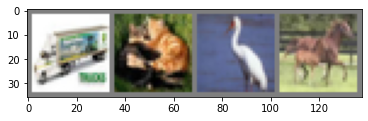

['truck', 'cat', 'bird', 'horse']


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(list( classes[labels[i]] for i in range(len(labels))))

## 2. CNN 정의하기

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
net = Net()

## 3. 손실함수와 Optimizer 정의하기

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## 4. 신경망 학습하기

In [13]:
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0
    print(loss.item())
    print(f"{epoch+1} epoch, loss: {loss.item():.3f}")


 10%|█         | 1/10 [00:49<07:22, 49.12s/it]

0.9095098972320557
1 epoch, loss: 0.910


 20%|██        | 2/10 [01:42<06:54, 51.84s/it]

0.7336756587028503
2 epoch, loss: 0.734


 30%|███       | 3/10 [02:41<06:26, 55.15s/it]

0.7096828818321228
3 epoch, loss: 0.710


 40%|████      | 4/10 [03:40<05:38, 56.46s/it]

1.5929248332977295
4 epoch, loss: 1.593


 50%|█████     | 5/10 [04:40<04:49, 57.88s/it]

1.3265173435211182
5 epoch, loss: 1.327


 60%|██████    | 6/10 [05:39<03:53, 58.26s/it]

1.7607979774475098
6 epoch, loss: 1.761


 70%|███████   | 7/10 [06:40<02:57, 59.04s/it]

2.107252359390259
7 epoch, loss: 2.107


 80%|████████  | 8/10 [07:38<01:57, 58.87s/it]

0.8022692203521729
8 epoch, loss: 0.802


 90%|█████████ | 9/10 [08:38<00:59, 59.03s/it]

1.4293955564498901
9 epoch, loss: 1.429


100%|██████████| 10/10 [09:43<00:00, 58.37s/it]

0.4737929701805115
10 epoch, loss: 0.474


In [14]:
# 학습된 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. 시험용 데이터로 신경망 검사하기

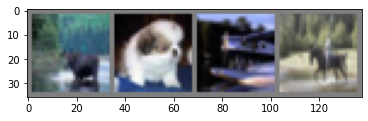

Ground Truth:  deer dog plane horse


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(f"Ground Truth: ", ' '.join(classes[labels[i]] for i in range(4)))

In [17]:
# 저장한 모델 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
outputs = net(images)

In [22]:
_, predicted = torch.max(outputs, 1)

print(f"Predicted: ", ' '.join(classes[predicted[i]] for i in range(4)))

In [24]:
# 전체 데이터셋에 대한 정확도
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"Accuracy: {100 * correct / total}%")

Accuracy: 64.19%


In [29]:
# 어떤 class를 잘 분류했는지 확인
n = len(classes)

class_correct = [0.0]*n
class_total = [0.0]*n

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(n):
    print(f"Accuracy of {classes[i]}: {100*class_correct[i] / class_total[i]}")

Accuracy of plane: 75.2
Accuracy of car: 73.2
Accuracy of bird: 55.6
Accuracy of cat: 46.0
Accuracy of deer: 46.0
Accuracy of dog: 53.8
Accuracy of frog: 78.9
Accuracy of horse: 68.0
Accuracy of ship: 73.8
Accuracy of truck: 71.4
